In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
from scipy import integrate 
from scipy import optimize
from scipy import stats
from scipy.interpolate import interp1d
from datetime import datetime
from metpy.units import units
from siphon.simplewebservice.wyoming import WyomingUpperAir

# Read data

In [2]:
%run profile_read_py.py

In [3]:
arquivo = '/Volumes/GoogleDrive/My Drive/Estudos/IC/Henrique/Programs/RMlicelPython/RM1183023.324' #30 agosto 2011

read = profile_read(arquivo)
phy  = read[1]

df = pd.DataFrame(phy)

# Aqui é um jeito provisório de fazer o header

lista = []
for i in range(len(read[0]['ch']['active'])):
    wlen = str(read[0]['ch']['wlen'][i])
    pol = str(read[0]['ch']['pol'][i])
    photon = read[0]['ch']['photons'][i]
    an = 'analog' if photon == 0 else 'photon'
    tr = read[0]['ch']['tr'][i]
    lista.append(wlen + ' ' + pol + ' ' + an + ' ' + tr[-1])

###############################################


df.columns = lista
alt = 7.5*(np.array(df.index) + 1)

df['alt'] = alt
s355 = df['355 o analog 0']

df.set_index('alt', inplace=True)

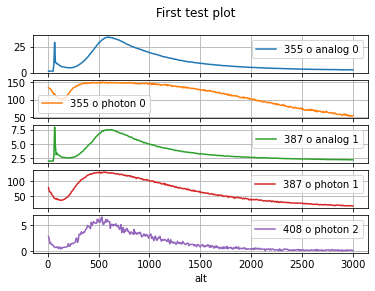

In [4]:
plot = df[:3000].plot(grid=True, subplots=True, title='First test plot')

# Reading multiple data (mean signal)

The idea here is to iterate over the data files in a month directory.

In [5]:
import os

directory = '/Volumes/GoogleDrive/My Drive/Estudos/IC/Henrique/Programs/RMlicelPython/30'

initial = 0
final = 0 + 30             # Tomando medias de 30 minutos

data = np.zeros((4000, final - initial))
cont = 0

for filename in os.listdir(directory)[initial:final]:
    path = os.path.join(directory, filename)
    read = profile_read(path)
    data[:, cont] = read[1][:, 0]
    phy = read[1]
    cont += 1
    #print(data)

## Para conferir se os dados estão sendo lidos

In [6]:
#os.listdir(directory)

In [7]:
df = pd.DataFrame(data)
#df.columns = lista
df

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,1.637573,1.616821,1.618856,1.620076,1.596883,1.624552,1.618245,1.678263,1.594442,1.618042,...,1.620076,1.628825,1.617635,1.595459,1.602376,1.677043,1.609497,1.615397,1.661987,1.664225
1,1.634318,1.609701,1.619059,1.620687,1.592407,1.628215,1.618856,1.700236,1.598511,1.621094,...,1.621908,1.623942,1.621704,1.595459,1.600342,1.667887,1.610514,1.611328,1.664225,1.666463
2,1.634725,1.613566,1.621908,1.619263,1.594849,1.629232,1.617839,1.700033,1.595052,1.617839,...,1.617025,1.626383,1.619466,1.597087,1.602173,1.668701,1.609701,1.611125,1.666870,1.674601
3,1.630046,1.609904,1.617635,1.622314,1.599731,1.630656,1.617839,1.688029,1.596069,1.622518,...,1.623535,1.628418,1.625977,1.595052,1.600952,1.659546,1.609497,1.614787,1.666667,1.668091
4,1.635742,1.607056,1.613159,1.617635,1.594442,1.629232,1.620076,1.702271,1.595459,1.615397,...,1.619466,1.625977,1.620076,1.600952,1.609090,1.678060,1.610514,1.613566,1.670532,1.666260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1.635539,1.620076,1.621501,1.624756,1.597493,1.631063,1.619670,1.692505,1.602580,1.621094,...,1.626383,1.631877,1.615601,1.599935,1.606852,1.673177,1.622925,1.624552,1.662191,1.672160
3996,1.631673,1.621094,1.626790,1.624146,1.601562,1.626180,1.628825,1.695760,1.594645,1.622111,...,1.626994,1.630249,1.624552,1.599121,1.601969,1.672567,1.617025,1.623128,1.688639,1.669108
3997,1.630249,1.616618,1.624349,1.624146,1.595866,1.629639,1.626383,1.694539,1.605632,1.625366,...,1.628621,1.634725,1.621094,1.597900,1.610718,1.673787,1.619670,1.614380,1.681315,1.673787
3998,1.632080,1.625773,1.623942,1.629028,1.595459,1.629435,1.622721,1.699422,1.603394,1.630859,...,1.628825,1.636353,1.619873,1.602173,1.609294,1.682536,1.619873,1.621094,1.656291,1.674398


In [8]:
s355 = df.mean(axis=1)
s355

0       1.638272
1       1.638021
2       1.638685
3       1.638285
4       1.639479
          ...   
3995    1.642551
3996    1.643094
3997    1.642497
3998    1.643209
3999    1.642164
Length: 4000, dtype: float64

# Applying corrections to signal data

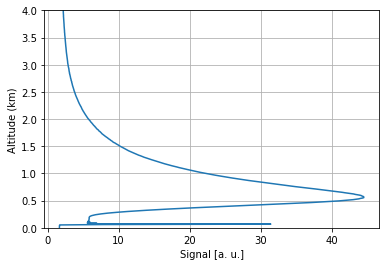

In [9]:
plt.plot(s355, alt*1e-3)
plt.grid(True)
plt.ylabel('Altitude (km)')
plt.xlabel('Signal [a. u.]')
plt.ylim(0, 4)
plt.savefig('fig1', dpi=200)

## Picture for $log(P r^2)$

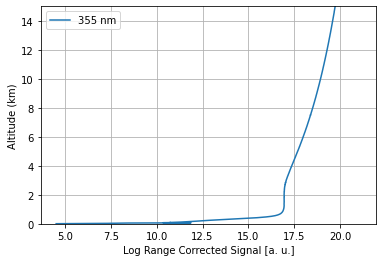

In [10]:
plt.plot(np.log(s355*alt*alt), alt*1e-3)
plt.grid(True)
plt.legend(['355 nm'])
plt.ylabel('Altitude (km)')
plt.xlabel('Log Range Corrected Signal [a. u.]')
plt.ylim(0, 15)
plt.savefig('fig3', dpi=200)

# Read temperature and pressure data

## Usando perfil artificial

z = alt
Pair = read[0]['P0']*np.exp(-(z-100)/8e3)    # H aproximadamente 8km
Tair = read[0]['T0'] - (9.8*1e-3)*z    # 6.5 lapse rate

Pair *= 100
Pair

plt.plot(Pair, alt*1e-3)
plt.grid(True)
plt.xlabel('Pressure [pa]')
plt.ylabel('Altitude [km]')
plt.ylim(0, 15)
plt.savefig('fig4', dpi=200)

Tair = read[0]['T0']+273.15 -0.006666666666668182*alt[:int(12000/7.5)]
Tair_p = Tair[-1]*np.ones(len(alt[int(12000/7.5):]))
Tair = np.concatenate((Tair, Tair_p), axis=0)

plt.plot(Tair, alt*1e-3)
plt.grid(True)
plt.xlabel('Temperature [K]')
plt.ylabel('Altitude [km]')
plt.ylim(0, 15)
plt.savefig('fig5', dpi=200)

PairTair = pd.read_fwf('PairTair.txt', header=None)

PairTair

## Usando dados de Wyoming

In [11]:
head = read[0]
date = datetime.strptime(head['datei'], '%d/%m/%Y').date()
station = 'SBMN'

PairTair = WyomingUpperAir.request_data(date, station)

In [12]:
PairTair.head()

,pressure,height,temperature,dewpoint,direction,speed,u_wind,v_wind,station,station_number,time,latitude,longitude,elevation,pw
0,1001.0,84,28.8,22.8,80.0,1.0,-0.984808,-0.173648,SBMN,82332,2011-08-30,-3.15,-59.98,84.0,44.19
1,1000.0,93,29.0,23.0,80.0,1.0,-0.984808,-0.173648,SBMN,82332,2011-08-30,-3.15,-59.98,84.0,44.19
2,992.0,165,31.6,22.6,81.0,2.0,-1.975377,-0.312869,SBMN,82332,2011-08-30,-3.15,-59.98,84.0,44.19
3,986.0,220,31.6,21.6,81.0,3.0,-2.963065,-0.469303,SBMN,82332,2011-08-30,-3.15,-59.98,84.0,44.19
4,947.0,581,28.7,20.0,85.0,10.0,-9.961947,-0.871557,SBMN,82332,2011-08-30,-3.15,-59.98,84.0,44.19


In [13]:
PairTair.units

{'pressure': 'hPa',
 'height': 'meter',
 'temperature': 'degC',
 'dewpoint': 'degC',
 'direction': 'degrees',
 'speed': 'knot',
 'u_wind': 'knot',
 'v_wind': 'knot',
 'station': None,
 'station_number': None,
 'time': None,
 'latitude': 'degrees',
 'longitude': 'degrees',
 'elevation': 'meter',
 'pw': 'millimeter'}

In [14]:
Pair = 100*PairTair['pressure']
Tair = 273.15 + PairTair['temperature']

bg = np.mean(s355[-500:])  # O background eh a media dos ultimos 500 bins
n_alt = alt[11:3145]       # Preciso ajustar o tamanho dos arrays de altitude e sinal
                           # pra poder fazer a interpolacao
n_s355 = s355[11:3145]     # '''

x = PairTair['height']
y = Pair
f = interp1d(x, y, kind='cubic')
newPair = f(n_alt)


y = Tair
f = interp1d(x, y, kind='cubic')
newTair = f(n_alt)

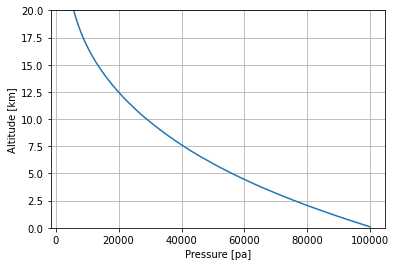

In [15]:
plt.plot(newPair, n_alt*1e-3)
plt.grid(True)
plt.xlabel('Pressure [pa]')
plt.ylabel('Altitude [km]')
plt.ylim(0, 20)
plt.savefig('Pres_profile', dpi=200)

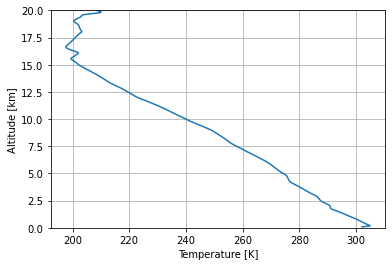

In [16]:
plt.plot(newTair, n_alt*1e-3)
plt.grid(True)
plt.xlabel('Temperature [K]')
plt.ylabel('Altitude [km]')
plt.ylim(0, 20)
plt.savefig('Temp_profile', dpi=200)

# Molecular Scattering

In [17]:
%run alphabeta.ipynb

In [18]:
lambd = 355*1e-9
co2 = 400


alpha_mol, beta_mol, LR_mol = alphabeta(newPair, newTair, lambd, co2)

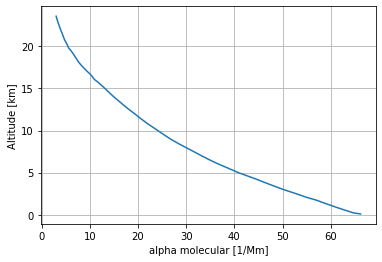

In [19]:
plt.plot(alpha_mol*1e6, n_alt*1e-3)
plt.grid(True)
plt.xlabel('alpha molecular [1/Mm]')
plt.ylabel('Altitude [km]')
plt.savefig('fig6', dpi=200)

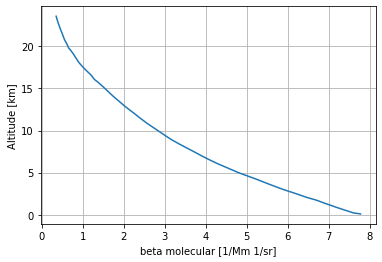

In [20]:
plt.plot(beta_mol*1e6, n_alt*1e-3)
plt.grid(True)
plt.xlabel('beta molecular [1/Mm 1/sr]')
plt.ylabel('Altitude [km]')
plt.savefig('fig7', dpi=200)

# Obtaining overlap

In [21]:
overlap = pd.read_csv('overlap_narrow.csv', header=None)
alt_o = alt[:overlap.shape[0]]
overlap['alt'] = alt_o
overlap.set_index('alt', inplace=True)
overlap

,0,1,2,3,4,5,6,7,8,9,...,88,89,90,91,92,93,94,95,96,97
alt,,,,,,,,,,,,,,,,,,,,,
7.5,0.000077,0.000090,0.000096,0.000059,0.000063,0.000068,0.000072,0.000096,0.000062,0.000070,...,0.000076,0.000058,0.000040,0.000047,0.000053,0.000042,0.000070,0.000101,0.000112,0.000300
15.0,0.000107,0.000121,0.000129,0.000083,0.000089,0.000095,0.000101,0.000131,0.000088,0.000098,...,0.000106,0.000080,0.000055,0.000065,0.000073,0.000059,0.000092,0.000134,0.000149,0.000397
22.5,0.000140,0.000156,0.000165,0.000110,0.000118,0.000126,0.000132,0.000168,0.000117,0.000131,...,0.000139,0.000105,0.000071,0.000085,0.000096,0.000078,0.000115,0.000169,0.000189,0.000502
30.0,0.000179,0.000195,0.000206,0.000143,0.000154,0.000164,0.000170,0.000212,0.000152,0.000170,...,0.000180,0.000135,0.000092,0.000110,0.000123,0.000101,0.000143,0.000209,0.000234,0.000621
37.5,0.000224,0.000240,0.000252,0.000181,0.000194,0.000206,0.000213,0.000260,0.000193,0.000216,...,0.000225,0.000169,0.000115,0.000138,0.000154,0.000127,0.000172,0.000251,0.000283,0.000751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14970.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
14977.5,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
14985.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


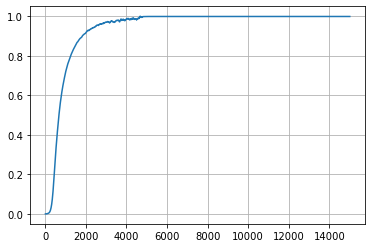

In [22]:
plt.plot(overlap[0])
plt.grid()

# Analisando a mudança dos overlaps

In [23]:
overlap_std = np.std(overlap, axis=1)
overlap_std

alt
7.5        0.000036
15.0       0.000047
22.5       0.000060
30.0       0.000074
37.5       0.000090
             ...   
14970.0    0.000000
14977.5    0.000000
14985.0    0.000000
14992.5    0.000000
15000.0    0.000000
Length: 2000, dtype: float64

In [24]:
alt_max = np.where(alt == 750)[0][0]

In [25]:
N = overlap.shape[1]
corr_matrix = np.zeros((N, N))
#print(N)
overlap_corr = stats.pearsonr(overlap[0], overlap[1])

for i in range(N):
    for j in range(i, N):
        #print(i, j)
        corr_matrix[i, j] = stats.pearsonr(overlap[i][:alt_max], overlap[j][:alt_max])[0]
        corr_matrix[j, i] = corr_matrix[i, j]

<AxesSubplot:xlabel='alt'>

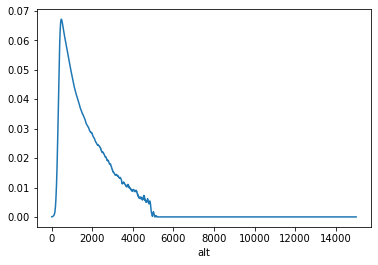

In [26]:
overlap_std.plot()

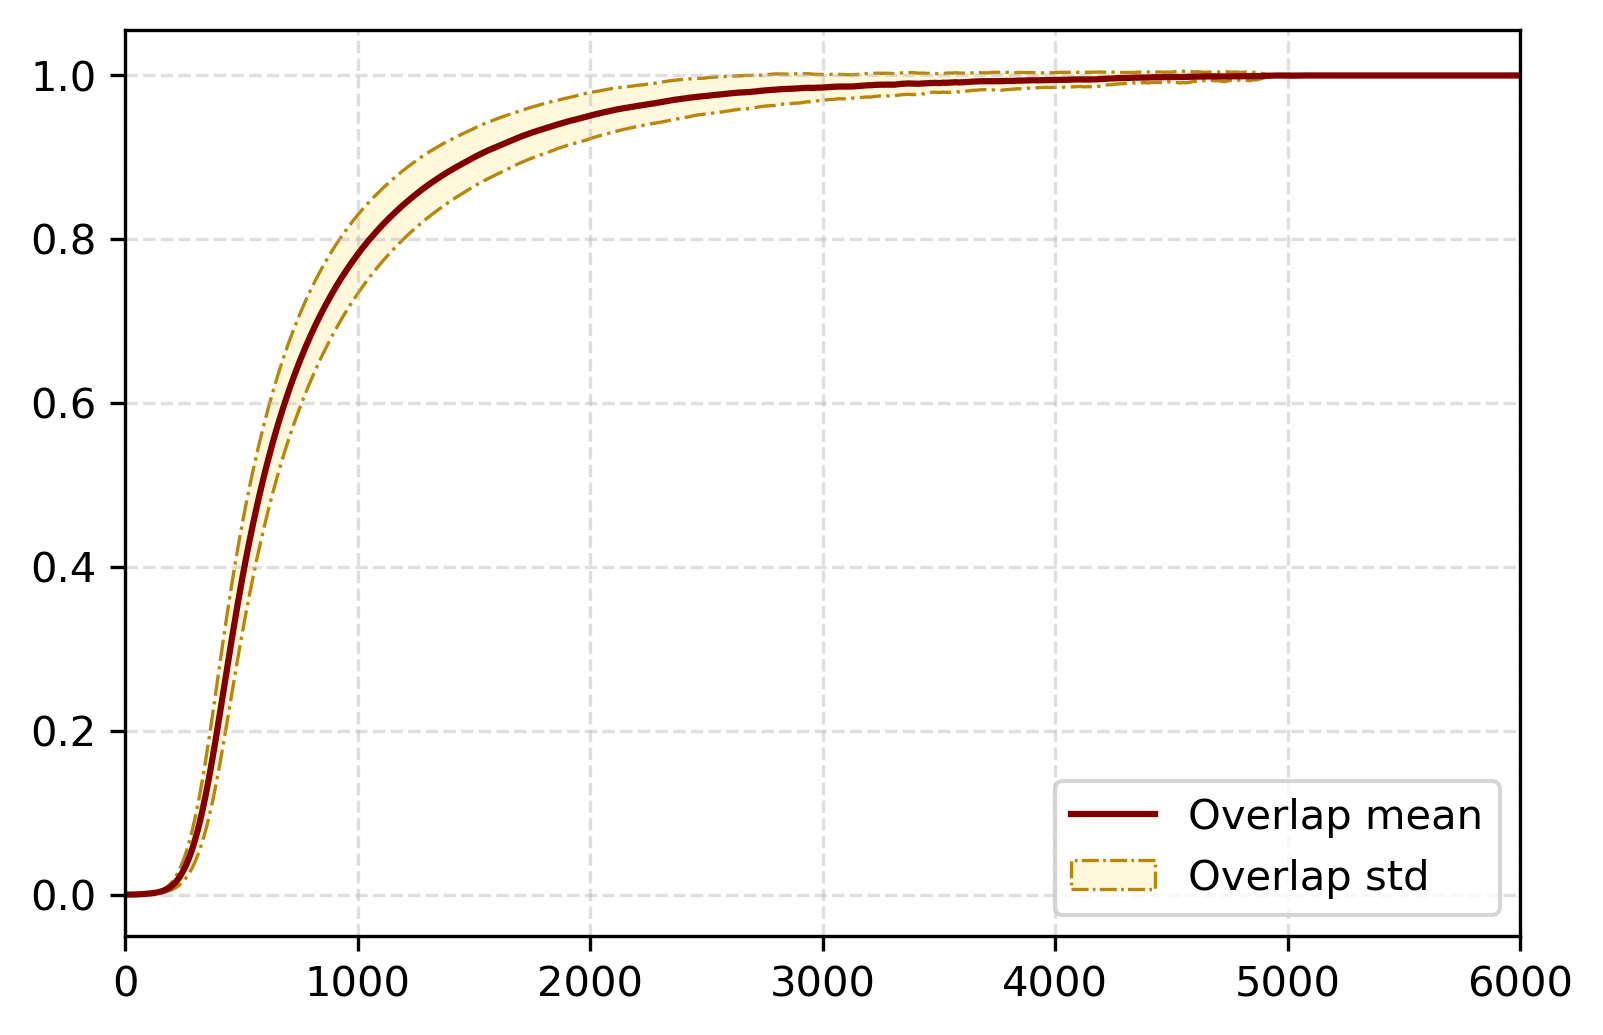

In [27]:
overlap_mean = np.mean(overlap, axis=1)
plt.figure(dpi=300)
#plt.plot(overlap)
plt.plot(alt_o, overlap_mean, color='maroon', label='Overlap mean')
plt.fill_between(alt_o, overlap_mean-overlap_std, overlap_mean+overlap_std, facecolor='cornsilk', 
                 edgecolor='darkgoldenrod', label='Overlap std', linestyle='-.',
                linewidth=0.8, alpha=1)
plt.grid(linestyle='--', linewidth=0.8, alpha=0.4)
plt.xlim(0, 6000)
plt.legend()
plt.show()

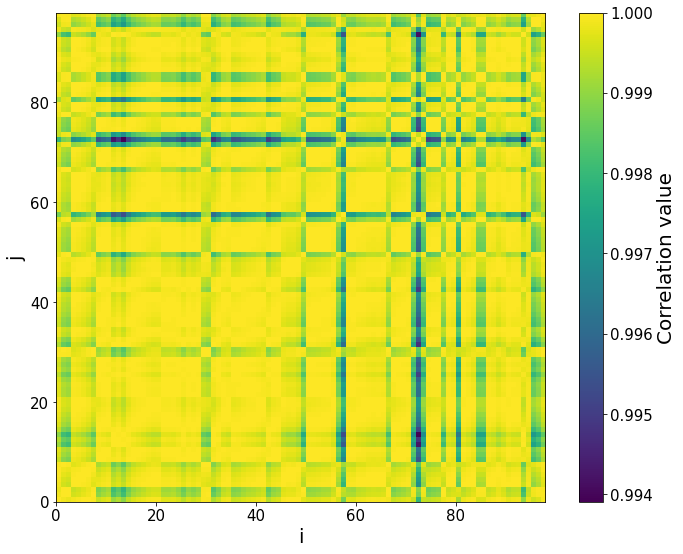

In [28]:
fig, ax = plt.subplots(figsize = (12,9))

psm = ax.imshow(corr_matrix, origin='lower', extent=[0, N, 0, N])

cbar = fig.colorbar(psm, ax=ax, label = "Correlation value")
cbar.ax.tick_params(labelsize=15)

ax.set_xlabel("i", fontsize=20)

ax.set_ylabel("j", fontsize=20)

cbar.ax.tick_params(labelsize=15)

ax.tick_params(labelsize=15)

ax.figure.axes[-1].yaxis.label.set_size(20)

# built the simulated molecular signal

In [29]:
s355_bg = s355 - bg          # Subtraindo o background
s355_bg = np.concatenate((s355_bg[:2000]/overlap_mean.values, s355_bg[2000:]), axis=0)   #Dividindo pelo overlap
n_alt = alt[11:3145]
n_s355 = s355_bg[11:3145]

In [30]:
meteo_alt = n_alt

In [31]:
model = (beta_mol * np.exp(-2*integrate.cumtrapz(alpha_mol, meteo_alt, initial=0))) / meteo_alt**2

(1e-10, 1000000000000000.0)

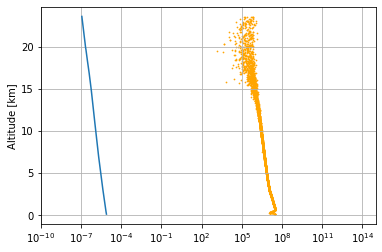

In [32]:
plt.semilogx(model*meteo_alt*meteo_alt, meteo_alt*1e-3)
plt.scatter((n_s355)*n_alt*n_alt, n_alt*1e-3, s=0.5, c='orange')
plt.grid(True)
plt.ylabel('Altitude [km]')
plt.xlim(1e-10, 1e15)

## Determinando a região do ajuste

In [33]:
alt_min = 8.   # km
alt_max = 15   # km

index_min = int(alt_min*1e3/7.5)
index_max = int(alt_max*1e3/7.5)

Text(0, 0.5, 'Measured signal')

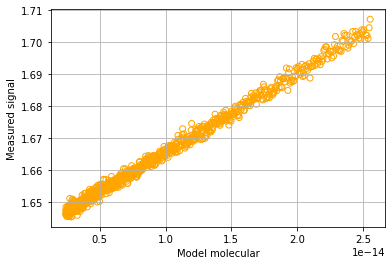

In [34]:
plt.scatter(model[index_min:index_max], s355[index_min:index_max], facecolors = 'none', edgecolors = 'orange')
plt.grid(True)
plt.xlabel('Model molecular')
plt.ylabel('Measured signal')

In [35]:
f = lambda x, a, b: a*x + b

fit = optimize.curve_fit(f, model[index_min:index_max], n_s355[index_min:index_max], p0=(1e13, 116))

a = fit[0][0]
b = fit[0][1]

fit

(array([ 2.38856195e+12, -2.27380283e-03]),
 array([[ 3.97629891e+19, -3.66000070e+05],
        [-3.66000070e+05,  4.88410627e-09]]))

Text(0, 0.5, 'Measured signal')

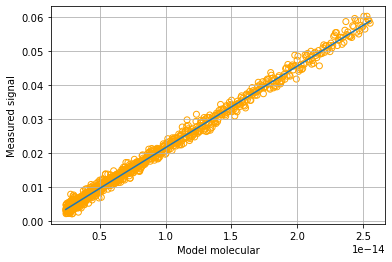

In [36]:
plt.scatter(model[index_min:index_max], n_s355[index_min:index_max], facecolors = 'none', edgecolors = 'orange')
plt.plot(model[index_min:index_max], f(model[index_min:index_max], a, b))
plt.grid(True)
plt.xlabel('Model molecular')
plt.ylabel('Measured signal')

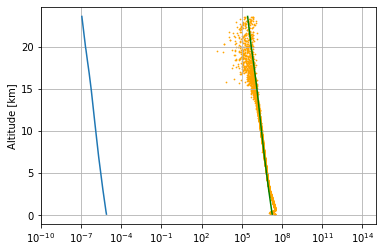

In [37]:
plt.semilogx(model*meteo_alt*meteo_alt, meteo_alt*1e-3)
plt.scatter((n_s355)*n_alt*n_alt, n_alt*1e-3, c='orange', s=0.5)
plt.semilogx(model*a*meteo_alt*meteo_alt, meteo_alt*1e-3, c='green')
plt.grid(True)
plt.ylabel('Altitude [km]')
plt.xlim(1e-10, 1e15)
plt.savefig('fig8', dpi=200)

In [38]:
%run fernald_new1.ipynb

# Devemos sempre entrar com vetores coluna no algoritmo de inversao

zref = np.array([6*1e3, 14*1e3])
LR = 28.

z = n_alt[:, None]
pr = n_s355[:, None]
ref = zref[:, None]
lambd = 355*1e-9
LidarRatio = LR
Pair = newPair[:, None]
Tair = newTair[:, None]


beta_par, alpha_par, LR_par, model_mol, ab_fit = fernald_new1(z,pr,ref,lambd,LidarRatio,Pair,Tair)

## Devemos restringir o plot a partir de 750m porque antes o overlap varia mto

In [39]:
lim = 100
beta_par['aer']  = beta_par['aer'][lim:]
beta_par['mol']  = beta_par['mol'][lim:]
beta_par['tot']  = beta_par['tot'][lim:]
alpha_par['aer'] = alpha_par['aer'][lim:]
alpha_par['mol'] = alpha_par['mol'][lim:]
alpha_par['tot'] = alpha_par['tot'][lim:]
n_alt = n_alt[lim:]

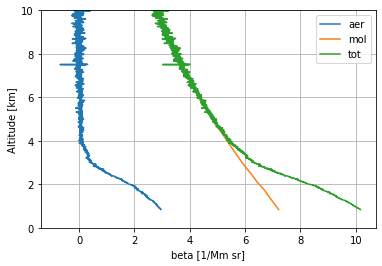

In [40]:
plt.plot(beta_par['aer']*1e6, n_alt*1e-3)
plt.plot(beta_par['mol']*1e6, n_alt*1e-3)
plt.plot(beta_par['tot']*1e6, n_alt*1e-3)
plt.grid(True)
plt.legend(['aer', 'mol', 'tot'])
# plt.xlim(-5, 14)
plt.ylim(0, 10)
plt.xlabel('beta [1/Mm sr]')
plt.ylabel('Altitude [km]')
plt.savefig('backscatter', dpi=200)

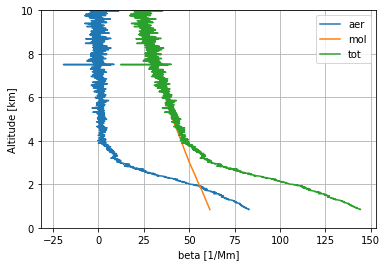

In [41]:
plt.plot(alpha_par['aer']*1e6, n_alt*1e-3)
plt.plot(alpha_par['mol']*1e6, n_alt*1e-3)
plt.plot(alpha_par['tot']*1e6, n_alt*1e-3)
plt.grid(True)
plt.legend(['aer', 'mol', 'tot'])
# plt.xlim(-5, 14)
plt.ylim(0, 10)
plt.xlabel('beta [1/Mm]')
plt.ylabel('Altitude [km]')
plt.savefig('alpha', dpi=200)